# Importing Packages

In [37]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoLocator
from matplotlib.pyplot import hist
from shapely.geometry import Point
import geopandas as gpd
import seaborn as sns 
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
%matplotlib inline

# 1.1 Cleaning Messy Outcome Labels


## Loading the cases

In [38]:
cases_train = pd.read_csv('../data/cases_2021_train.csv')
cases_test = pd.read_csv('../data/cases_2021_test.csv')

## Outcome Distribution

In [39]:
cases_train.groupby('outcome').size()

outcome
Alive                               127
Dead                                  9
Death                                 4
Deceased                           3361
Died                                  4
Discharged                            2
Discharged from hospital              3
Hospitalized                     135524
Receiving Treatment                 183
Recovered                         62875
Stable                               24
Under treatment                     243
critical condition                    1
death                                29
died                                624
discharge                           114
discharged                           82
recovered                          2435
recovering at home 03.03.2020         2
released from quarantine              3
stable                              107
stable condition                     90
dtype: int64

## Filling Outcome_Group 


In [40]:
hospitalzed = ['Discharged', 'Discharged from hospital', 'Hospitalized', 'critical condition',
'discharge', 'discharged']
nonhospitalized = ['Alive', 'Receiving Treatment', 'Stable', 'Under treatment', 'recovering at home 03.03.2020', 'released from quarantine', 'stable', 'stable condition']
deceased = ['Dead', 'Death', 'Deceased', 'Died', 'death', 'died']
recovered = ['Recovered','recovered']




In [41]:
cases_train.loc[cases_train["outcome"].isin(hospitalzed), "outcome_group"] ='hospitalized'
cases_train.loc[cases_train["outcome"].isin(nonhospitalized), "outcome_group"] ='nonhospitalized'
cases_train.loc[cases_train["outcome"].isin(deceased), "outcome_group"] ='deceased'
cases_train.loc[cases_train["outcome"].isin(recovered), "outcome_group"] ='recovered'
cases_train = cases_train.drop(columns="outcome")

# 1.3 Exploratory Data Analysis


## Distribution of the attributes

### CASES 2021 TRAIN

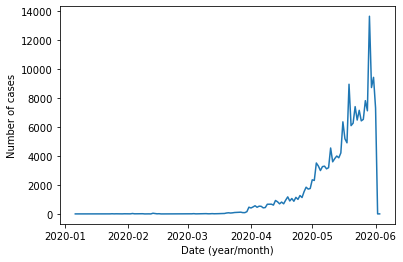

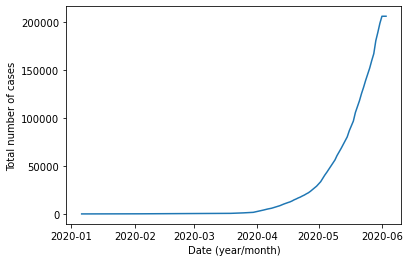

In [42]:
by_day=cases_train['date_confirmation'].value_counts().rename_axis('date').reset_index(name='counts')
by_day['date']=pd.to_datetime(by_day['date'], errors='coerce',infer_datetime_format=True)
by_day['counts']=by_day['counts'].astype(int)
by_day=by_day.sort_values(by='date')
by_day=by_day.dropna(axis=0)
totals=[]
totals.append(by_day['counts'].iloc[0])
for i in range(1,137):
       totals.append(totals[i-1]+by_day['counts'].iloc[i])
by_day['totals']=totals

plt.plot(by_day['date'],by_day['counts'])
plt.xlabel('Date (year/month)')
plt.ylabel('Number of cases')
plt.savefig('../plots/task1.3/dateVnumber.png')
plt.show()
plt.plot(by_day['date'],by_day['totals'])
plt.xlabel('Date (year/month)')
plt.ylabel('Total number of cases')
plt.savefig('../plots/task1.3/dateVtotal.png')

In [43]:
cases_train.groupby('outcome_group').size()

outcome_group
deceased             4031
hospitalized       135726
nonhospitalized       779
recovered           65310
dtype: int64

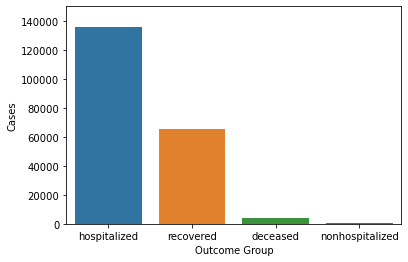

In [44]:
p = sns.countplot(x="outcome_group",data= cases_train)
p.set(xlabel="Outcome Group", ylabel="Cases")
p.set(ylim=(0,150000))
p = p.get_figure()
p.savefig("../plots/task1.3/distribution_outcome.png")

#### Analysing Cases With Hospital Outcome

##### Hospitalized Against Date

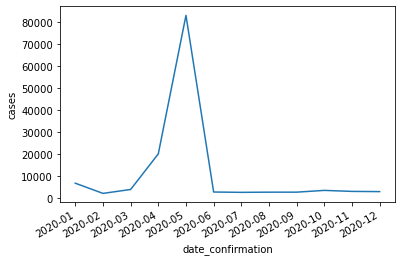

In [45]:
cases_train_hosp = cases_train.loc[cases_train['outcome_group'] =='hospitalized']
cases_train_hosp['date_confirmation'] = cases_train_hosp['date_confirmation'].astype('datetime64[ns]')
cases_train_hosp['date_confirmation'] = cases_train_hosp['date_confirmation'].dt.strftime('%Y-%m')
date = cases_train_hosp.groupby('date_confirmation').size().to_frame('cases')
p = sns.lineplot(x="date_confirmation",y="cases",data = date)
p.get_figure().autofmt_xdate()
p = p.get_figure()
p.savefig("../plots/task1.3/distribution_hospital_date.png")

##### Map Plot of Hospitalized Cases


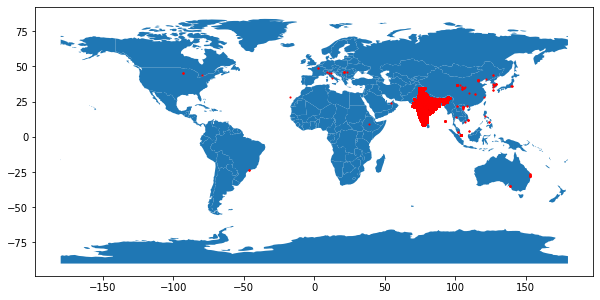

In [46]:

geometry = [Point(xy) for xy in zip(cases_train_hosp['longitude'], cases_train_hosp['latitude'])]
glocation_data = GeoDataFrame(cases_train_hosp, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
glocation_data.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=5);
plt.savefig("../plots/task1.3/world_hosp.png")



##### Hospitalized Against Longitude

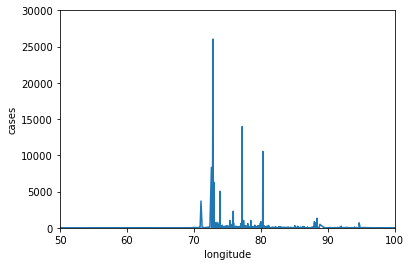

In [47]:
longitude = cases_train_hosp.groupby('longitude').size().to_frame('cases')
p = sns.lineplot(x="longitude",y="cases",data = longitude)
p.set(xlim=(50,100))
p.set(ylim=(0,30000))
p = p.get_figure()
p.savefig("../plots/task1.3/longitude_hospital_date.png")

##### Hospitalized Against Latitude

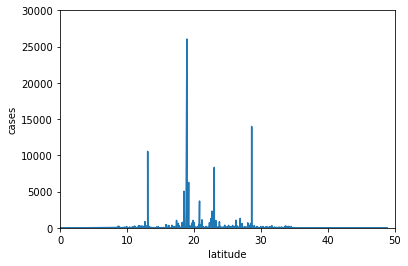

In [48]:
latitude = cases_train_hosp.groupby('latitude').size().to_frame('cases')
p= sns.lineplot(x="latitude",y="cases",data = latitude)
p.set(xlim=(0,50))
p.set(ylim=(0,30000))
p = p.get_figure()
p.savefig("../plots/task1.3/latitudehospital_date.png")

#### Analysing Cases With Recovered Outcome

##### Recovered Against Date

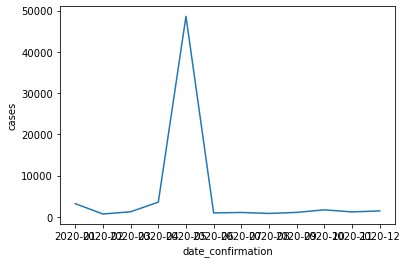

In [49]:

cases_train_recov= cases_train.loc[cases_train['outcome_group'] =='recovered']
cases_train_recov['date_confirmation'] = cases_train_recov['date_confirmation'].astype('datetime64[ns]')
cases_train_recov['date_confirmation'] = cases_train_recov['date_confirmation'].dt.strftime('%Y-%m')
date = cases_train_recov.groupby('date_confirmation').size().to_frame('cases')
p = sns.lineplot(x="date_confirmation",y="cases",data = date)
p = p.get_figure()
p.savefig("../plots/task1.3/distribution_recovered_date.png")

##### Map Plot of Recovered Cases

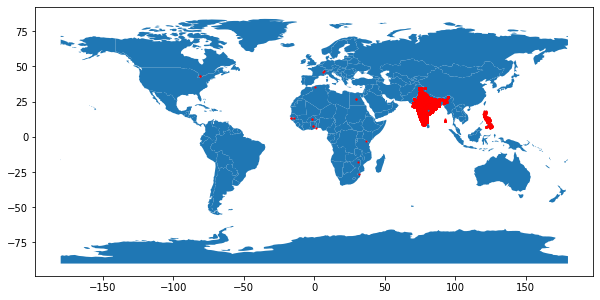

In [50]:

geometry = [Point(xy) for xy in zip(cases_train_recov['longitude'], cases_train_recov['latitude'])]
glocation_data = GeoDataFrame(cases_train_recov, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
glocation_data.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=5)
plt.savefig("../plots/task1.3/world_recov.png")

##### Recovered Against Longitude

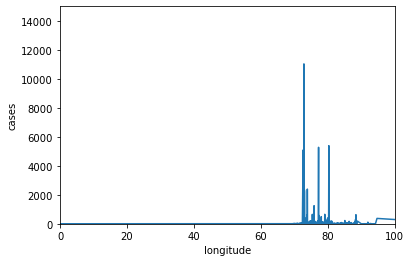

In [51]:
longitude = cases_train_recov.groupby('longitude').size().to_frame('cases')
p = sns.lineplot(x="longitude",y="cases",data = longitude)
p.set(xlim=(0,100))
p.set(ylim=(0,15000))
p = p.get_figure()
p.savefig("../plots/task1.3/longitude_recovered_.png")


##### Recoverd Against Latitude

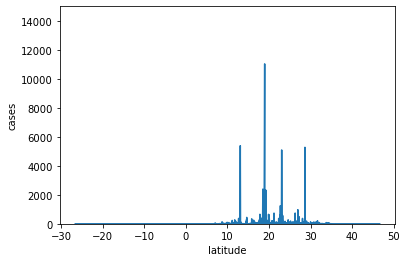

In [52]:
latitude = cases_train_recov.groupby('latitude').size().to_frame('cases')
p= sns.lineplot(x="latitude",y="cases",data = latitude)
p.set(ylim=(0,15000))
p = p.get_figure()
p.savefig("../plots/task1.3/latitude_recovered_.png")

#### Analysing Cases With Deceased Outcome

##### Deceased Against Date

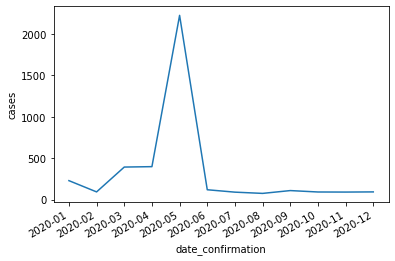

In [53]:
cases_train_dec= cases_train.loc[cases_train['outcome_group'] =='deceased']
cases_train_dec.loc[cases_train_dec['date_confirmation'].str.len() > 10,"date_confirmation"] = "26.02.2020"
cases_train_dec['date_confirmation'] = cases_train_dec['date_confirmation'].astype('datetime64[ns]')
cases_train_dec['date_confirmation'] = cases_train_dec['date_confirmation'].dt.strftime('%Y-%m')
date = cases_train_dec.groupby('date_confirmation').size().to_frame('cases')
p = sns.lineplot(x="date_confirmation",y="cases",data = date)
p.get_figure().autofmt_xdate()
p = p.get_figure()
p.savefig("../plots/task1.3/deceased_date.png")

##### Map Plot of Deceased Cases

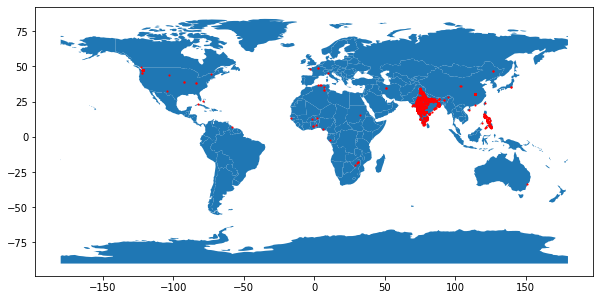

In [54]:

geometry = [Point(xy) for xy in zip(cases_train_dec['longitude'], cases_train_dec['latitude'])]
glocation_data = GeoDataFrame(cases_train_dec, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
glocation_data.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=5)
plt.savefig("../plots/task1.3/world_dec.png")

##### Deceased Against Longitude

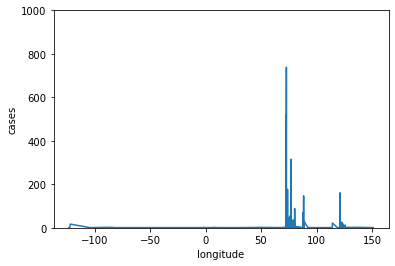

In [55]:
longitude = cases_train_dec.groupby('longitude').size().to_frame('cases')
p = sns.lineplot(x="longitude",y="cases",data = longitude)
p.set(ylim=(0,1000))
p = p.get_figure()
p.savefig("../plots/task1.3/long_dec.png")

##### Deceased Against Latitude

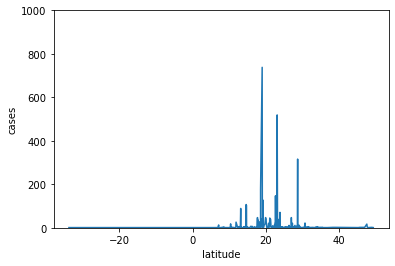

In [56]:
latitude = cases_train_dec.groupby('latitude').size().to_frame('cases')
p= sns.lineplot(x="latitude",y="cases",data = latitude)
p.set(ylim=(0,1000))
p = p.get_figure()
p.savefig("../plots/task1.3/lat_dec.png")

#### Analysing Cases With Non-Hospitalized Outcome

##### Nonhospitalized Against Date

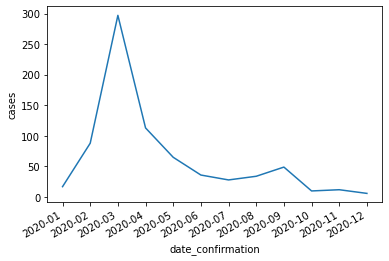

In [57]:
cases_train_nonhosp= cases_train.loc[cases_train['outcome_group'] =='nonhospitalized']
cases_train_nonhosp['date_confirmation'] = cases_train_nonhosp['date_confirmation'].astype('datetime64[ns]')
cases_train_nonhosp['date_confirmation'] = cases_train_nonhosp['date_confirmation'].dt.strftime('%Y-%m')
date = cases_train_nonhosp.groupby('date_confirmation').size().to_frame('cases')
p = sns.lineplot(x="date_confirmation",y="cases",data = date)
p.get_figure().autofmt_xdate()
p = p.get_figure()
p.savefig("../plots/task1.3/nonhosp_date.png")

##### Map Plot of Non Hospitalized Cases

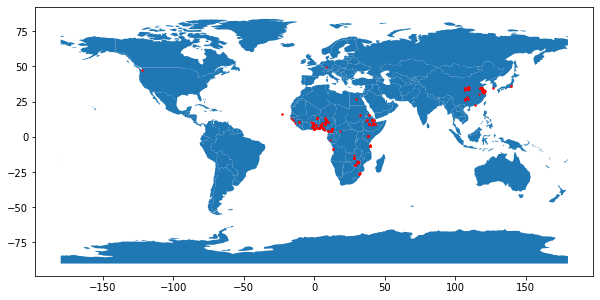

In [58]:

geometry = [Point(xy) for xy in zip(cases_train_nonhosp['longitude'], cases_train_nonhosp['latitude'])]
glocation_data = GeoDataFrame(cases_train_nonhosp, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
glocation_data.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=5)
plt.savefig("../plots/task1.3/world_nonhosp.png")

##### NonHospitalized Against Longitude

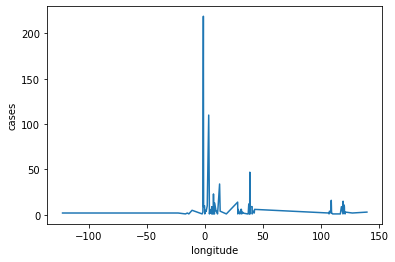

In [59]:
longitude = cases_train_nonhosp.groupby('longitude').size().to_frame('cases')
p = sns.lineplot(x="longitude",y="cases",data = longitude)
p = p.get_figure()
p.savefig("../plots/task1.3/nonhosp_long.png")

##### Non Hospitalized Against Latitude

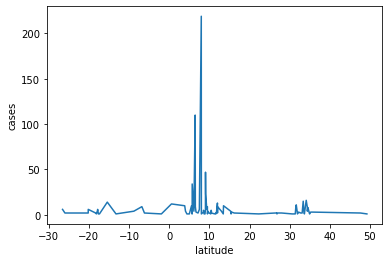

In [60]:
latitude = cases_train_nonhosp.groupby('latitude').size().to_frame('cases')
p= sns.lineplot(x="latitude",y="cases",data = latitude)
p = p.get_figure()
p.savefig("../plots/task1.3/nonhosp_lat.png")

#### Plotting All Cases on World Map

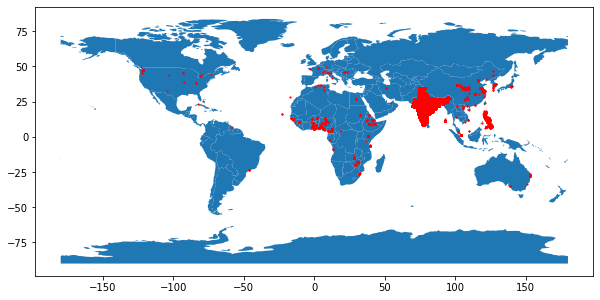

In [61]:
geometry = [Point(xy) for xy in zip(cases_train['longitude'], cases_train['latitude'])]
glocation_data = GeoDataFrame(cases_train, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
glocation_data.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=5)
plt.savefig("../plots/task1.3/world_all.png")

### CASES 2021 TEST

In [62]:
cases_test1=cases_test['country'].value_counts().rename_axis('country').reset_index(name='counts')
cases_test1['counts']=cases_test1['counts'].astype(int)
cases_test1=cases_test1.drop(labels=0,axis=0)
cases_test1=cases_test1.drop(labels=1,axis=0)

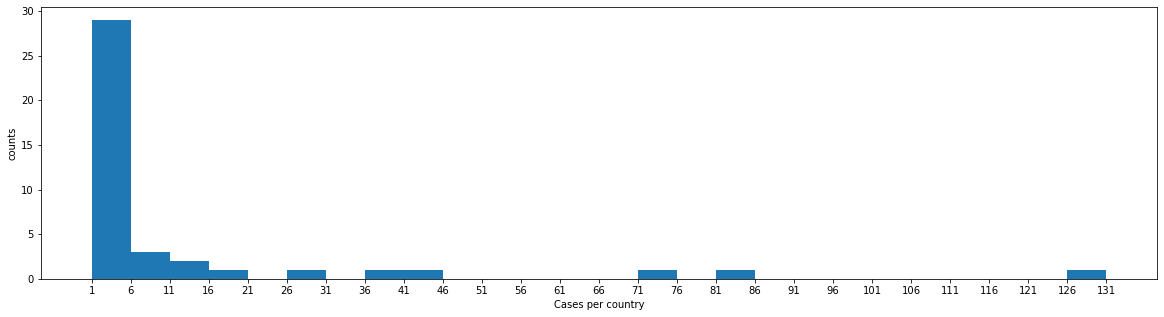

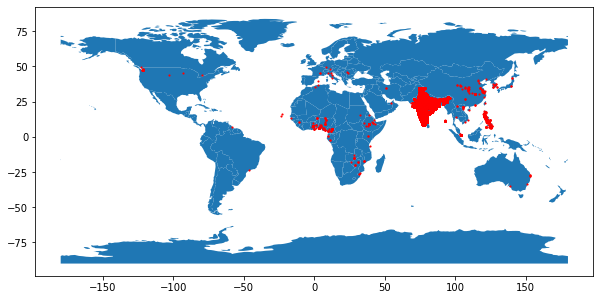

In [63]:
plt.figure(figsize=(20, 5))
plt.hist(cases_test1['counts'],bins=26)
plt.xticks(np.linspace(1,131,27))
plt.xlabel('Cases per country')
plt.ylabel('counts')
plt.savefig('../plots/task1.3/cases_per_country.png')
plt.show()

geometry = [Point(xy) for xy in zip(cases_test['longitude'], cases_test['latitude'])]
glocation_data = GeoDataFrame(cases_test, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
glocation_data.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=5);

### LOCATION 2021

In [64]:
location_data=pd.read_csv('../data/location_2021.csv')
location_data
location_totals=location_data.groupby('Country_Region').sum()
location_totals['Case_Fatality_Ratio']=100*(location_totals['Deaths'].div(location_totals['Confirmed']))
location_totals=location_totals.reset_index()
top10deaths=location_totals.sort_values(by='Deaths',ascending=False).head(10)
top10deaths



,Country_Region,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
182,US,121707.405039,-293182.487164,30531835,551457,0.0,559.0,2.975722e+07,1.806171
23,Brazil,-342.077100,-1308.973300,12763392,322138,11181371.0,1246129.0,2.008472e+05,2.523922
115,Mexico,695.047500,-3216.873200,2238887,203210,1773236.0,2035677.0,5.377750e+04,9.076385
79,India,831.177882,2945.020567,12221665,162927,11474683.0,584055.0,4.435946e+04,1.333100
138,Peru,-265.933101,-1881.943595,1548807,143416,1468457.0,1396868.0,1.101603e+05,9.259772
186,United Kingdom,422.469698,-509.497466,4359982,126955,13073.0,4219954.0,5.202145e+04,2.911824
85,Italy,903.972147,256.745065,3584899,109346,2913045.0,562508.0,1.248980e+05,3.050184
144,Russia,4527.343882,5156.031399,4494234,97219,4118709.0,278306.0,2.621680e+05,2.163194
62,France,77.169695,-416.763414,4705186,95798,301467.0,4307921.0,4.928911e+04,2.036009
66,Germany,825.149500,164.446100,2843644,76589,2539660.0,227395.0,5.341854e+04,2.693340


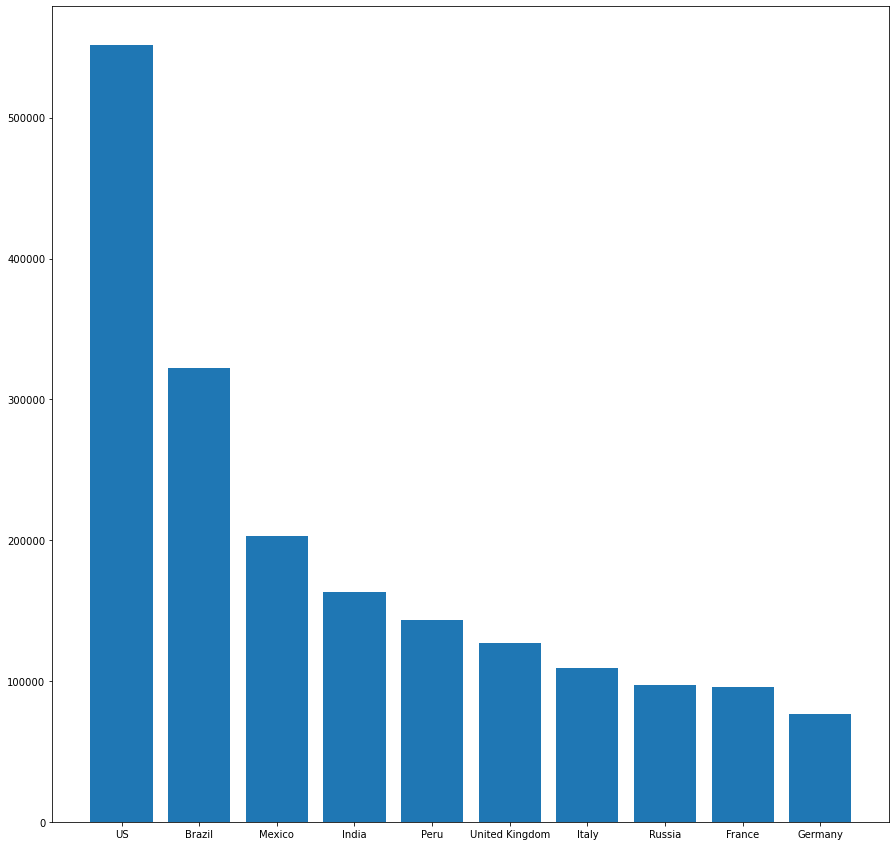

In [65]:
plt.figure(figsize=(15, 15))
plt.bar(top10deaths['Country_Region'],top10deaths['Deaths'])
plt.savefig('../plots/task1.3/top10.png')

## Number of missing values

In [66]:
cases_train.isna().sum()



age                       182793
sex                       180362
province                     604
country                        1
latitude                       0
longitude                      0
date_confirmation             51
additional_information    193444
source                     18394
chronic_disease_binary         0
outcome_group                  0
geometry                       0
dtype: int64

In [67]:
cases_test.isna().sum()

age                        90013
sex                        88765
province                     296
country                        1
latitude                       0
longitude                      0
date_confirmation             23
additional_information     95206
source                      9160
chronic_disease_binary         0
outcome_group             101387
geometry                       0
dtype: int64

In [68]:
location_data.isna().sum()

Province_State          174
Country_Region            0
Last_Update               0
Lat                      89
Long_                    89
Confirmed                 0
Deaths                    0
Recovered              3275
Active                 3275
Combined_Key              0
Incident_Rate            90
Case_Fatality_Ratio      48
dtype: int64